In [57]:
import numpy as np
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

In [58]:
# matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [60]:
# get player shotchart detail: player_name, season_id -> player_shotchart, league_avg

def get_player_shotchartdetail(player_name, season_id):
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # print(player_dict)
    
    # career dataframe
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # print(career_df)
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # print(team_id)
    
    #shotchartdetail endpoints
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                    player_id=int(player_dict['id']),
                                                    season_type_all_star='Regular Season',
                                                    season_nullable=season_id,
                                                    context_measure_simple="FGA").get_data_frames()
    
    # print(shotchartlist)
    
    return shotchartlist[0], shotchartlist[1]


In [101]:
player_dict

[{'id': 76001,
  'full_name': 'Alaa Abdelnaby',
  'first_name': 'Alaa',
  'last_name': 'Abdelnaby',
  'is_active': False},
 {'id': 76002,
  'full_name': 'Zaid Abdul-Aziz',
  'first_name': 'Zaid',
  'last_name': 'Abdul-Aziz',
  'is_active': False},
 {'id': 76003,
  'full_name': 'Kareem Abdul-Jabbar',
  'first_name': 'Kareem',
  'last_name': 'Abdul-Jabbar',
  'is_active': False},
 {'id': 51,
  'full_name': 'Mahmoud Abdul-Rauf',
  'first_name': 'Mahmoud',
  'last_name': 'Abdul-Rauf',
  'is_active': False},
 {'id': 1505,
  'full_name': 'Tariq Abdul-Wahad',
  'first_name': 'Tariq',
  'last_name': 'Abdul-Wahad',
  'is_active': False},
 {'id': 949,
  'full_name': 'Shareef Abdur-Rahim',
  'first_name': 'Shareef',
  'last_name': 'Abdur-Rahim',
  'is_active': False},
 {'id': 76005,
  'full_name': 'Tom Abernethy',
  'first_name': 'Tom',
  'last_name': 'Abernethy',
  'is_active': False},
 {'id': 76006,
  'full_name': 'Forest Able',
  'first_name': 'Forest',
  'last_name': 'Able',
  'is_active': Fa

In [61]:
# creating the court and visualisations

def draw_court(ax=None, color='blue', lw=1, outer_lines=False):
    if ax is None:
        ax = plt.gca()
        
    # Basketball Hoop
    hoop = Circle((0,0), radius=7.5, linewidth=lw, color=color, fill=False)
    
    # Backboard
    backboard = Rectangle((-30,-12.5), 60, 0, linewidth=lw, color=color)
    
    # the paint
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth = lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth = lw, color=color, fill=False)
    
    # freethrow
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                      restricted, corner_three_a, corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    
    for element in court_elements:
        ax.add_patch(element)
        
    return ax

In [62]:
def shot_chart(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="blue",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    # separate color by make or miss    
    x_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_X']
    y_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_Y']

    x_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_X']
    y_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_Y']

    # plot missed shots
    ax.scatter(x_missed, y_missed, c='r', marker="x", s=300, linewidths=3, **kwargs)
    # plot made shots
    ax.scatter(x_made, y_made, facecolors='none', edgecolors='g', marker="o", s=100, linewidths=3, **kwargs)
        
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

if __name__ == '__main__':
    player_shotchart_df, league_avg = get_player_shotchartdetail("LeBron James", "2019-20")
    
    # print(player_shotchart_df)
    # print(league_avg)
    
    xlim = (-250, 250)
    ylim = (422.5, -47.5)
    
    ax = plt.gca()
    ax.set_xlim(xlim[::-1])
    ax.set_ylim(ylim[::-1])
    draw_court(ax)
    plt.show()

In [63]:
from nba_api.stats.endpoints import playergamelog

# test whether can get sum of field goals made in a particular season
player_dict = players.get_players()
from nba_api.stats.endpoints import playergamelog

name = "LeBron James"
name = [player for player in player_dict if player['full_name'] == name][0]
name_id = name['id']
name_gamelog = playergamelog.PlayerGameLog(player_id=name_id, season='2019-20')
name_gamelog_df = name_gamelog.get_data_frames()[0]
name_fgm = name_gamelog_df['FGM'].sum()
name_fgm

In [95]:
def getPlayerSeasonStats():
    name = str(input("Enter the name of a player you would like to analyse: \n"))
    year = str(input("Enter the season year that you would like to analyse for that player: (e.g 2019-20)\n"))
    
    player_shotchart_df, league_avg = get_player_shotchartdetail(name, year)
    
    shot_chart(player_shotchart_df, title=f'{name} Shot Chart {year}')
    
    # Set the size for our plots
    plt.rcParams['figure.figsize'] = (12,11)
    plt.show()
    
    player_dict = players.get_players()

    aplayer = [player for player in player_dict if player['full_name'] == name][0]
    playerid = aplayer['id']
    player_gamelog = playergamelog.PlayerGameLog(player_id=playerid, season=year)
    player_gamelog_df = player_gamelog.get_data_frames()[0]
    player_fgm = player_gamelog_df['FGM'].sum()
    player_fgpercent = player_gamelog_df['FG_PCT'].mean()
    
    return (name, year, player_fgm, player_fgpercent)
    

Enter the name of a player you would like to analyse: 
LeBron James
Enter the season year that you would like to analyse for that player: (e.g 2019-20)
2019-20


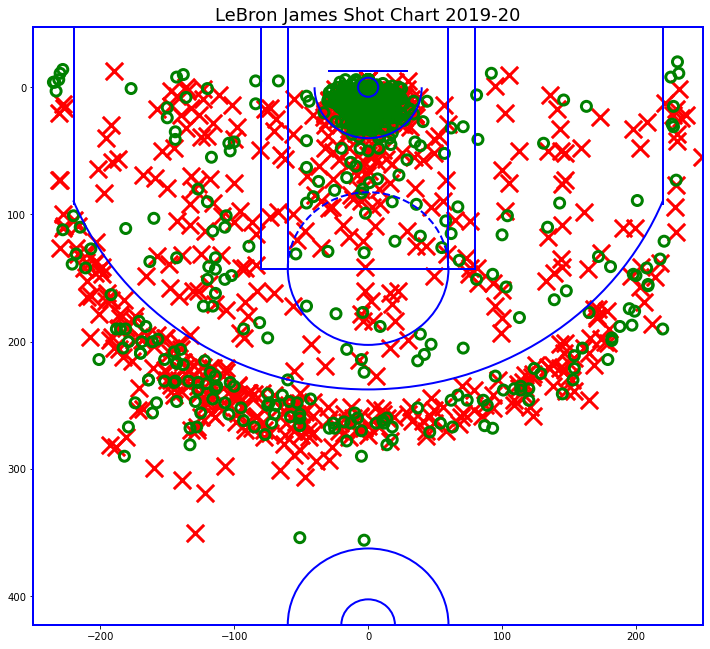

Number of field goals made by LeBron in season 2019-20 is: 643
LeBron James average field goal shots percentage in season 2019-20 is: 48.96%


In [99]:
x = getPlayerSeasonStats()

print(f'Number of field goals made by {x[0].split()[0]} in season {x[1]} is: {x[2]}')
print(f'{x[0]} average field goal shots percentage in season {x[1]} is: {round(x[3]*100,2)}%')